In [59]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

card_df = pd.read_csv('/content/creditcard.csv')
card_df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [60]:
card_df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

## 데이터의 비대칭 해결

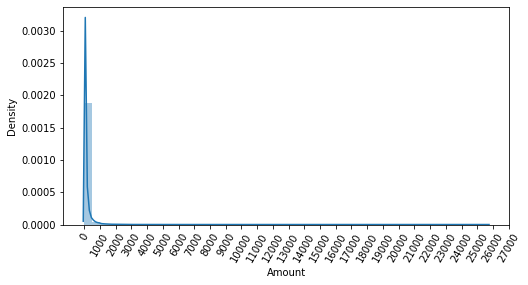

In [61]:
import seaborn as sns

plt.figure(figsize=(8, 4))
plt.xticks(range(0, 30000, 1000), rotation=60)
sns.distplot(card_df['Amount'])

In [62]:
from sklearn.preprocessing import StandardScaler
# 사이킷런의 StandardScaler를 이용하여 정규분포 형태로 Amount 피처값 변환하는 로직으로 수정. 

In [63]:
#중요
scaler = StandardScaler()
amount_n = scaler.fit_transform(card_df['Amount'].values.reshape(-1,1))
card_df.insert(0, 'Amount_Scaled', amount_n)
card_df.drop('Amount', axis=1, inplace=True)

## train

In [64]:
from sklearn.model_selection import train_test_split

# 인자로 입력받은 DataFrame을 복사 한 뒤 Time 컬럼만 삭제하고 복사된 DataFrame 반환
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    df_copy.drop('Time', axis=1, inplace=True)
    return df_copy

In [65]:
# 사전 데이터 가공 후 학습과 테스트 데이터 세트를 반환하는 함수.
def get_train_test_dataset(df=None):
    # 인자로 입력된 DataFrame의 사전 데이터 가공이 완료된 복사 DataFrame 반환
    df_copy = get_preprocessed_df(df)
    # DataFrame의 맨 마지막 컬럼이 레이블, 나머지는 피처들
    X_features = df_copy.iloc[:, :-1]
    y_target = df_copy.iloc[:, -1]
    # train_test_split( )으로 학습과 테스트 데이터 분할. stratify=y_target으로 Stratified 기반 분할
    X_train, X_test, y_train, y_test = train_test_split(X_features,y_target, test_size=0.3, random_state=0, stratify=y_target)
    # 학습과 테스트 데이터 세트 반환
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [66]:
print('학습 데이터 레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0] * 100)
print('테스트 데이터 레이블 값 비율')
print(y_test.value_counts()/y_test.shape[0] * 100)

학습 데이터 레이블 값 비율
0    99.827451
1     0.172549
Name: Class, dtype: float64
테스트 데이터 레이블 값 비율
0    99.826785
1     0.173215
Name: Class, dtype: float64


# XG Boost


In [67]:
import xgboost as xgb
from xgboost import plot_importance

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test , pred):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    roc_auc = roc_auc_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [68]:
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
evals = [(X_test, y_test)]
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="logloss", 
                eval_set=evals, verbose=True)
ws100_preds = xgb_wrapper.predict(X_test)

[0]	validation_0-logloss:0.598092
Will train until validation_0-logloss hasn't improved in 100 rounds.
[1]	validation_0-logloss:0.520255
[2]	validation_0-logloss:0.456007
[3]	validation_0-logloss:0.401221
[4]	validation_0-logloss:0.354408
[5]	validation_0-logloss:0.314741
[6]	validation_0-logloss:0.279638
[7]	validation_0-logloss:0.249109
[8]	validation_0-logloss:0.22249
[9]	validation_0-logloss:0.199196
[10]	validation_0-logloss:0.178123
[11]	validation_0-logloss:0.159847
[12]	validation_0-logloss:0.143749
[13]	validation_0-logloss:0.129313
[14]	validation_0-logloss:0.11633
[15]	validation_0-logloss:0.10469
[16]	validation_0-logloss:0.094425
[17]	validation_0-logloss:0.085203
[18]	validation_0-logloss:0.076953
[19]	validation_0-logloss:0.069552
[20]	validation_0-logloss:0.063019
[21]	validation_0-logloss:0.057033
[22]	validation_0-logloss:0.051701
[23]	validation_0-logloss:0.046873
[24]	validation_0-logloss:0.042538
[25]	validation_0-logloss:0.038613
[26]	validation_0-logloss:0.035058

In [69]:
get_clf_eval(y_test , ws100_preds)


오차 행렬
[[85289     6]
 [   41   107]]
정확도: 0.9994, 정밀도: 0.9469, 재현율: 0.7230,    F1: 0.8199, AUC:0.8615


# LightGBM

In [70]:
from lightgbm import LGBMClassifier

lgbm_wrapper = LGBMClassifier(n_estimators=400, boost_from_average = True)

evals = [(X_test, y_test)]
lgbm_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="logloss", 
                 eval_set=evals, verbose=True)
preds = lgbm_wrapper.predict(X_test)

[1]	valid_0's binary_logloss: 0.0130349	valid_0's binary_logloss: 0.0130349
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.0483536	valid_0's binary_logloss: 0.0483536
[3]	valid_0's binary_logloss: 0.0134134	valid_0's binary_logloss: 0.0134134
[4]	valid_0's binary_logloss: 0.0140827	valid_0's binary_logloss: 0.0140827
[5]	valid_0's binary_logloss: 0.0146976	valid_0's binary_logloss: 0.0146976
[6]	valid_0's binary_logloss: 0.0170486	valid_0's binary_logloss: 0.0170486
[7]	valid_0's binary_logloss: 0.0156368	valid_0's binary_logloss: 0.0156368
[8]	valid_0's binary_logloss: 0.0177323	valid_0's binary_logloss: 0.0177323
[9]	valid_0's binary_logloss: 0.0205379	valid_0's binary_logloss: 0.0205379
[10]	valid_0's binary_logloss: 0.021409	valid_0's binary_logloss: 0.021409
[11]	valid_0's binary_logloss: 0.0231373	valid_0's binary_logloss: 0.0231373
[12]	valid_0's binary_logloss: 0.0180461	valid_0's binary_logloss: 0.0180461
[13]	valid_0's binary_lo

In [71]:
get_clf_eval(y_test, preds)


오차 행렬
[[85227    68]
 [   33   115]]
정확도: 0.9988, 정밀도: 0.6284, 재현율: 0.7770,    F1: 0.6949, AUC:0.8881


# 하이퍼파라미터 튜닝

In [72]:
from sklearn.model_selection import GridSearchCV

xgb_clf = XGBClassifier(n_estimators=100)

params = {'max_depth':[5, 7] , 'min_child_weight':[1,3] ,'colsample_bytree':[0.5, 0.75] }

gridcv = GridSearchCV(xgb_clf, param_grid=params, cv=3)
gridcv.fit(X_train, y_train, early_stopping_rounds=30, eval_metric="auc",
           eval_set=[(X_train, y_train), (X_test, y_test)])

print('GridSearchCV 최적 파라미터:',gridcv.best_params_) 

xgb_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test)[:,1], average='macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.893804	validation_1-auc:0.841108
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.908212	validation_1-auc:0.874665
[2]	validation_0-auc:0.927081	validation_1-auc:0.908419
[3]	validation_0-auc:0.927087	validation_1-auc:0.908419
[4]	validation_0-auc:0.927092	validation_1-auc:0.908433
[5]	validation_0-auc:0.927091	validation_1-auc:0.908432
[6]	validation_0-auc:0.927095	validation_1-auc:0.908437
[7]	validation_0-auc:0.927024	validation_1-auc:0.908337
[8]	validation_0-auc:0.926981	validation_1-auc:0.908284
[9]	validation_0-auc:0.926981	validation_1-auc:0.908284
[10]	validation_0-auc:0.926981	validation_1-auc:0.908283
[11]	validation_0-auc:0.931282	validation_1-auc:0.908184
[12]	validation_0-auc:0.931258	validation_1-auc:0.908155
[13]	validation_0-auc:0.931258	validation_1-auc:0.908158
[14]	validation_0-auc:0.931256	validation_1-auc:0.90815

In [ ]:
xgb_clf = XGBClassifier(n_estimators=1000, colsample_bytree = 0.5, max_depth = 7, min_child_weight = 1, \
                       learning_rate = 0.02, reg_alpha=0.03)

xgb_clf.fit(X_train, y_train, early_stopping_rounds=200, eval_metric="auc",
           eval_set=[(X_train, y_train), (X_test, y_test)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1], average='macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

In [ ]:
lgbm_clf = LGBMClassifier(n_estimators=200)

params = {'num_leaves': [32, 64 ],
          'max_depth':[128, 160],
          'min_child_samples':[60, 100],
          'subsample':[0.8, 1]}

gridcv = GridSearchCV(lgbm_clf, param_grid=params)
gridcv.fit(X_train, y_train, early_stopping_rounds=30, eval_metric="auc",
           eval_set=[(X_train, y_train), (X_test, y_test)])

print('GridSearchCV 최적 파라미터:', gridcv.best_params_)
lgbm_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test)[:,1], average='macro')
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

In [ ]:
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=32, sumbsample=0.8, min_child_samples=100,
                          max_depth=128)

evals = [(X_test, y_test)]
lgbm_clf.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="auc", eval_set=evals,
                verbose=True)

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1],average='macro')
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))